# Gradiometry Simulation

In [2]:
import magpylib as magpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import random
from scipy.signal import chirp
import scipy.spatial.transform as st
from scipy.ndimage import uniform_filter1d
np.set_printoptions(precision=2)


In [3]:
m = magpy.misc.Dipole(moment=(0,0,1.8))
s1 = magpy.Sensor(position=(0,0,8.5))
s2 = magpy.Sensor(position=(0,0,6.8))
s3 = magpy.Sensor(position=(0,0,5.2))
s = [s1,s2,s3]
m.getB(s)*1e9

array([[0.  , 0.  , 0.59],
       [0.  , 0.  , 1.14],
       [0.  , 0.  , 2.56]])

Functions to load noise

In [ ]:
spacecraft_center = None
mag_positions = None

def noiseReactionWheel(fs, N, base_freq, seed):
    np.random.seed(seed) 
    shift_freq = np.random.uniform(1/50, base_freq)
    duration = int(np.random.uniform(1/50, 5/50))
    time_of_shift = np.random.randint(0, (N/fs) - (2*duration))

    # Define time array.
    t = np.arange(N) / fs

    # Create signal.
    signal_rw = np.sin(2 * np.pi * base_freq * t)

    # Create down-chirp signal.
    down_chirp_signal = chirp(t[:duration*fs], base_freq, duration, shift_freq, method='hyperbolic')
    # Create up-chirp signal
    up_chirp_signal = chirp(t[:duration*fs], shift_freq, duration, base_freq, method='hyperbolic')

    # Modify original signal with chirp signal.
    signal_rw[time_of_shift*fs:(time_of_shift+duration)*fs] = down_chirp_signal
    signal_rw[(time_of_shift+duration)*fs:(time_of_shift+2*duration)*fs] = up_chirp_signal

    return signal_rw

def noiseMichibiki():
    "Import the magnetometer data from the file"
    qzs_1 = np.loadtxt(r"utility\SPACE_DATA\michibiki.dat", dtype=float, usecols=(0,4,5,6,7,8,9))
    B_qzs = qzs_1.T

    "Subtract the bias from the magnetometer data"
    B_qzs[1] -= 60 # MAM-S1 X-Axis
    B_qzs[2] -= 410 # MAM-S1 Y-Axis
    B_qzs[3] -= -202 # MAM-S1 Z-Axis
    B_qzs[4] -= -528 # MAM-S2 X-Axis
    B_qzs[5] -= -200 # MAM-S2 Y-Axis
    B_qzs[6] -= 478 # MAM-S2 Z-Axis

    Bx = B_qzs[4] - B_qzs[1]
    By = B_qzs[5] - B_qzs[2]
    Bz = B_qzs[6] - B_qzs[3]
    michibiki = np.vstack((Bx,By,Bz))
    return(michibiki)

def noiseVEX():
    df  = pd.read_csv(r'utility\SPACE_DATA\VEX.txt',delimiter='\s+')
    B = np.array([[df['BISX'],df['BISY'],df['BISZ']],[df['BOSX'],df['BOSY'],df['BOSZ']]])
    B = B - uniform_filter1d(B, size=10000, axis=-1,mode='wrap')
    noise = B[1] - B[0]
    return(noise)

def noiseArcjet(N, seed = 0):
    # Defining a function that takes an integer N and an optional integer seed as parameters
    "Randomly Turn on and off signals" # A docstring that describes the function
    f = 500 # Setting a constant f
    np.random.seed(seed) # Setting the random seed for reproducibility
    zeros_ = np.random.choice([0, 1], size=(N // f + 1,), p=[3./10, 7./10]) # Generating an array of 0's and 1's with a 10% chance of 0 and a 90% chance of 1, with a size of N // f + 1
    ones_ = np.ones(N) # Generating an array of 1's with a size of N
    for i in range(N//f + 1): # Looping through the indices of the zeros_ array
        if(zeros_[i] == 1): # If the element at the current index is 1
            ones_[i*f:min((i+1)*f, N)] = 0 # Set the corresponding f elements or the remaining elements in the ones_ array to 0
    return(ones_) # Return the ones_ array as the output

def createMixingMatrix(seed, axis = 0):
    random.seed(seed)
    np.random.seed(seed)

    "Create Sensors"
    s1 = magpy.Sensor(position=(0, 0, 5.2), style_size=1.8)
    s2 = magpy.Sensor(position=(0, 0, 6.8), style_size=1.8)
    s3 = magpy.Sensor(position=(0, 0, 8.5), style_size=1.8)
    
    s = [s1, s2, s3]
    global mag_positions
    mag_positions = [s1.position,s2.position, s3.position]


    "Create Sources"
    ### TODO DO case where M is all Z and M is all X
    d1 = magpy.misc.Dipole(position=(random.uniform(-1, 1), random.uniform(-3, 3), random.uniform(-2, 0)), orientation=st.Rotation.random(), moment=(0, 0, random.uniform(2, 6)))
    d2 = magpy.misc.Dipole(position=(random.uniform(-1, 1), random.uniform(-3, 3), random.uniform(-2, 0)), orientation=st.Rotation.random(), moment=(0, 0, random.uniform(2, 6)))
    d3 = magpy.misc.Dipole(position=(random.uniform(-1, 1), random.uniform(-3, 3), random.uniform(-2, 0)), orientation=st.Rotation.random(), moment=(0, 0, random.uniform(2, 6)))
    d4 = magpy.misc.Dipole(position=(random.uniform(-1, 1), random.uniform(-3, 3), random.uniform(-2, 0)), orientation=st.Rotation.random(), moment=(0, 0, random.uniform(2, 6)))
    src = [d1,d2,d3,d4]

    global spacecraft_center
    spacecraft_center = np.sum([d.position*d.moment[-1] for d in src], axis = 0)/np.sum([d.moment[-1] for d in src])

    if False: plotNoiseFields([s1,s2],src)

    mixingMatrix = np.zeros((5,len(s)))
    mixingMatrix[0] = np.ones(len(s))

    for i in range(len(src)):
        mixing_vector = (src[i].getB(s)*1e9).T[axis]
        mixingMatrix[i+1] = mixing_vector

    return(mixingMatrix.T)

def createMixingMatrixBoomless(seed, axis = 0):
    random.seed(seed)
    np.random.seed(seed)

    "Create Sensors"
    s1 = magpy.Sensor(position=(1.1, 3.1, 0), style_size=1.8)
    s2 = magpy.Sensor(position=(1.1, -3.1, -2.1), style_size=1.8)
    s3 = magpy.Sensor(position=(0, 0, 5.2), style_size=1.8)
    
    s = [s1, s2, s3]



    "Create Sources"
    ### TODO DO case where M is all Z and M is all X
    d1 = magpy.misc.Dipole(position=(random.uniform(-1, 1), random.uniform(-3, 3), random.uniform(-2, 0)), orientation=st.Rotation.random(), moment=(0, 0, random.uniform(2, 6)))
    d2 = magpy.misc.Dipole(position=(random.uniform(-1, 1), random.uniform(-3, 3), random.uniform(-2, 0)), orientation=st.Rotation.random(), moment=(0, 0, random.uniform(2, 6)))
    d3 = magpy.misc.Dipole(position=(random.uniform(-1, 1), random.uniform(-3, 3), random.uniform(-2, 0)), orientation=st.Rotation.random(), moment=(0, 0, random.uniform(2, 6)))
    d4 = magpy.misc.Dipole(position=(random.uniform(-1, 1), random.uniform(-3, 3), random.uniform(-2, 0)), orientation=st.Rotation.random(), moment=(0, 0, random.uniform(2, 6)))
    src = [d1,d2,d3,d4]

    global spacecraft_center
    spacecraft_center = np.sum([d.position*d.moment[-1] for d in src], axis = 0)/np.sum([d.moment[-1] for d in src])

    mixingMatrix = np.zeros((5,len(s)))
    mixingMatrix[0] = np.ones(len(s))

    for i in range(len(src)):
        mixing_vector = (src[i].getB(s)*1e9).T[axis]
        mixingMatrix[i+1] = mixing_vector

    return(mixingMatrix.T)

def randomizeSignals(N, seed = 0):
    # Defining a function that takes an integer N and an optional integer seed as parameters
    "Randomly Turn on and off signals" # A docstring that describes the function
    f = 300 # Setting a constant f to 300
    np.random.seed(seed) # Setting the random seed for reproducibility
    zeros_ = np.random.choice([0, 1], size=(N // f + 1,), p=[1./10, 9./10]) # Generating an array of 0's and 1's with a 10% chance of 0 and a 90% chance of 1, with a size of N // f + 1
    ones_ = np.ones(N) # Generating an array of 1's with a size of N
    for i in range(N//f + 1): # Looping through the indices of the zeros_ array
        if(zeros_[i] == 1): # If the element at the current index is 1
            ones_[i*f:min((i+1)*f, N)] = 0 # Set the corresponding f elements or the remaining elements in the ones_ array to 0
    return(ones_) # Return the ones_ array as the output

def snr(x, y):
  # x and y are numpy arrays of the same length
  # x is the original signal and y is the noisy signal
  # returns the SNR in decibels
  x_mean = np.mean(x) # calculate the mean of x
  num = np.sum((x - x_mean)**2) # calculate the numerator of SNR
  den = np.sum((x - y)**2) # calculate the denominator of SNR
  if den == 0: # avoid division by zero
    return np.inf # return infinity if denominator is zero
  else:
    return 10 * np.log10(num / den) # return SNR in decibels


<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_20716\159149108.py:47: SyntaxWarning: invalid escape sequence '\s'
  df  = pd.read_csv(r'utility\SPACE_DATA\VEX.txt',delimiter='\s+')


Load Satellite Data

In [5]:
duration = 5000; sampleRate = 1; N = duration*sampleRate; T = 1/sampleRate
samples = np.linspace(0, duration, N, endpoint=False)
signals = np.zeros((5, samples.shape[0]))

"Import ambient magnetic field signal."
df=pd.read_csv(r'utility\SPACE_DATA\Swarm_MAGA_HR_20150317_0900.csv', sep=',',header=None)
r = df[10]
swarm = np.array([np.fromstring(r[i][1:-1], dtype=float, sep=' ') for i in range(1, r.shape[0])]).T[:,160000:160000+N]

"Import Nosie Data"
michibiki = noiseMichibiki()
vex = noiseVEX()

C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_20716\818574337.py:6: DtypeWarning: Columns (2,5,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(r'utility\SPACE_DATA\Swarm_MAGA_HR_20150317_0900.csv', sep=',',header=None)


Create Source and Mixed Signals

In [6]:
def createNoise(i):
    random.seed(i)
    np.random.seed(i)

    n = random.randint(0, michibiki.shape[-1]-5000)

    "Create Source Signals"
    signals[0] = swarm[0]
    signals[1] = noiseReactionWheel(sampleRate, N, np.random.uniform(4/50,sampleRate/2), i) # Reaction Wheels
    signals[2] = (michibiki[0][n:n+5000]-np.mean(michibiki[0][n:n+5000]))/np.max(np.abs((michibiki[0][n:n+5000]-np.mean(michibiki[0][n:n+5000])))) # Michibiki
    signals[3] = noiseArcjet(N, i) # Arcjet
    signals[4] = (vex[0][n:n+5000]-np.mean(vex[0][n:n+5000]))/np.max(np.abs((vex[0][n:n+5000]-np.mean(vex[0][n:n+5000])))) # Michibiki

    "Create Mixing Matrices"
    Kx = createMixingMatrix(i, 0)
    Ky = createMixingMatrix(i, 1)
    Kz = createMixingMatrix(i, 2)

    "Create Mixed Signals"
    Bx = Kx @ signals

    signals[0] = swarm[1]
    signals[2] = (michibiki[1][n:n+5000]-np.mean(michibiki[1][n:n+5000]))/np.max(np.abs((michibiki[1][n:n+5000]-np.mean(michibiki[1][n:n+5000]))))
    By = Ky @ signals

    signals[0] = swarm[2]
    signals[2] = (michibiki[2][n:n+5000]-np.mean(michibiki[2][n:n+5000]))/np.max(np.abs((michibiki[2][n:n+5000]-np.mean(michibiki[2][n:n+5000]))))
    Bz = Kz @ signals
    
    "Create B"
    B = np.array([Bx,By,Bz])
    B = np.swapaxes(B,0,1)
    return(B, Kx, Ky, Kz)

def createNoiseBoomless(i):
    random.seed(i)
    np.random.seed(i)

    n = random.randint(0, michibiki.shape[-1]-5000)

    "Create Source Signals"
    signals[0] = swarm[0]
    signals[1] = noiseReactionWheel(sampleRate, N, np.random.uniform(4/50,sampleRate/2), i) # Reaction Wheels
    signals[2] = (michibiki[0][n:n+5000]-np.mean(michibiki[0][n:n+5000]))/np.max(np.abs((michibiki[0][n:n+5000]-np.mean(michibiki[0][n:n+5000])))) # Michibiki
    signals[3] = noiseArcjet(N, i) # Arcjet
    signals[4] = (vex[0][n:n+5000]-np.mean(vex[0][n:n+5000]))/np.max(np.abs((vex[0][n:n+5000]-np.mean(vex[0][n:n+5000])))) # Michibiki

    "Create Mixing Matrices"
    Kx = createMixingMatrixBoomless(i, 0)
    Ky = createMixingMatrixBoomless(i, 1)
    Kz = createMixingMatrixBoomless(i, 2)

    "Create Mixed Signals"
    Bx = Kx @ signals

    signals[0] = swarm[1]
    signals[2] = (michibiki[1][n:n+5000]-np.mean(michibiki[1][n:n+5000]))/np.max(np.abs((michibiki[1][n:n+5000]-np.mean(michibiki[1][n:n+5000]))))
    By = Ky @ signals

    signals[0] = swarm[2]
    signals[2] = (michibiki[2][n:n+5000]-np.mean(michibiki[2][n:n+5000]))/np.max(np.abs((michibiki[2][n:n+5000]-np.mean(michibiki[2][n:n+5000]))))
    Bz = Kz @ signals
    
    "Create B"
    B = np.array([Bx,By,Bz])
    B = np.swapaxes(B,0,1)
    return(B, Kx, Ky, Kz)

Clean Data

In [8]:
from algorithms import NEUBAUER, WAICUP, HOG, UBSS, RAMEN
import os
import pandas as pd
import importlib
importlib.reload(NEUBAUER)
importlib.reload(WAICUP)
importlib.reload(HOG)
importlib.reload(UBSS)
importlib.reload(RAMEN)
np.set_printoptions(precision=4, suppress=True)


# Define the CSV file path
csv_file = 'results_boomless.csv'

# Define the column names
columns = [
    'iteration', 'dKx', 'dKy', 'dKz',
    # RMSE Metrics for each algorithm and axis
    'rmse_neubauer_x', 'rmse_neubauer_y', 'rmse_neubauer_z',
    'rmse_B2_x', 'rmse_B2_y', 'rmse_B2_z',
    'rmse_B1_x', 'rmse_B1_y', 'rmse_B1_z',
    'rmse_B0_x', 'rmse_B0_y', 'rmse_B0_z',
    'rmse_waicup_x', 'rmse_waicup_y', 'rmse_waicup_z',
    'rmse_ramen_x', 'rmse_ramen_y', 'rmse_ramen_z',
    'rmse_hog_x', 'rmse_hog_y', 'rmse_hog_z',
    'rmse_ubss_x', 'rmse_ubss_y', 'rmse_ubss_z',
    # SNR Metrics for each algorithm and axis
    'snr_neubauer_x', 'snr_neubauer_y', 'snr_neubauer_z',
    'snr_B2_x', 'snr_B2_y', 'snr_B2_z',
    'snr_waicup_x', 'snr_waicup_y', 'snr_waicup_z',
    'snr_hog_x', 'snr_hog_y', 'snr_hog_z',
    'snr_ramen_x', 'snr_ramen_y', 'snr_ramen_z',
    'snr_ubss_x', 'snr_ubss_y', 'snr_ubss_z'
]
# If the CSV does not exist, create it with headers
if not os.path.isfile(csv_file):
    df = pd.DataFrame(columns=columns)
    df.to_csv(csv_file, index=False)

# Loop through the desired range
for i in range(35):
    B, Kx, Ky, Kz = createNoise(i)
    B_boomless, Kx_boomless, Ky_boomless, Kz_boomless = createNoiseBoomless(i)
    dKx = np.std(Kx[[0],1:] / Kx[[2],1:])
    dKy = np.std(Ky[[0],1:] / Ky[[2],1:])
    dKz = np.std(Kz[[0],1:] / Kz[[2],1:])
    B += np.random.normal(0, 0.008, B.shape)
    B_boomless += np.random.normal(0, 0.008, B_boomless.shape)

    "NEUBAUER"
    NEUBAUER.mag_positions = np.array(mag_positions)
    NEUBAUER.spacecraft_center = spacecraft_center 
    NEUBAUER.optimize_center = False
    result_neubauer = NEUBAUER.clean(np.copy(B))

    "UBSS"
    importlib.reload(UBSS)
    UBSS.sigma = 10         # Magnitude Filter Threshold
    UBSS.bpo = 1            # Number of Bands Per Octave in the NSGT Transform
    UBSS.fs = 1              # Sampling Frequency
    UBSS.weight = 1.2          # Weight for Compressive Sensing
    UBSS.cs_iters = 3        # Number of Iterations for Compressive Sensing
    result_ubss =  UBSS.clean(np.copy(B_boomless))

    "Subspace UBSS"
    importlib.reload(UBSS)
    UBSS.sigma = 10         # Magnitude Filter Threshold
    UBSS.bpo = 1            # Number of Bands Per Octave in the NSGT Transform
    UBSS.fs = 1              # Sampling Frequency
    UBSS.subspace = True
    UBSS.cs_iters = 10        # Number of Iterations for Compressive Sensing
    result_subspace =  UBSS.clean(np.copy(B_boomless))

    "RMSE"
    rmse_neubauer = np.sqrt(((swarm.T-result_neubauer.T)**2).mean(axis=0))
    rmse_B2= np.sqrt(((swarm.T-B[-1].T)**2).mean(axis=0))
    rmse_B1 = np.sqrt(((swarm.T-B[1].T)**2).mean(axis=0))
    rmse_B0 = np.sqrt(((swarm.T-B[0].T)**2).mean(axis=0))
    rmse_subspace = np.sqrt(((swarm.T-result_subspace.T)**2).mean(axis=0))
    rmse_ubss = np.sqrt(((swarm.T-result_ubss.T)**2).mean(axis=0))
    print("BOOM: ", rmse_B2)
    print("NEUBAUER: ", rmse_neubauer)
    print("UBSS: ", rmse_ubss)
    print("Subspace", rmse_subspace )

   

c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
100%|██████████| 6194/6194 [00:13<00:00, 470.05it/s]
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
100%|██████████| 6194/6194 [00:13<00:00, 450.10it/s]
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
100%|██████████| 6194/6194 [00:13<00:00, 475.05it/s]
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  

BOOM:  [0.1839 0.1403 0.274 ]
NEUBAUER:  [2.2117 1.1825 3.5096]
UBSS:  [3.0272 4.7347 1.2538]
Subspace [3.0106 4.6947 1.2527]


c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
100%|██████████| 6194/6194 [00:18<00:00, 327.37it/s]
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
100%|██████████| 6194/6194 [00:18<00:00, 332.16it/s]
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
100%|██████████| 6194/6194 [00:21<00:00, 290.00it/s]
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  

BOOM:  [0.2433 0.4098 0.6347]
NEUBAUER:  [129.3899 207.5941 269.972 ]
UBSS:  [16.4534 12.6154 14.0568]
Subspace [ 29.4546 151.527   22.2894]


c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
100%|██████████| 6194/6194 [01:04<00:00, 95.83it/s] 
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
100%|██████████| 6194/6194 [00:15<00:00, 404.18it/s]
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
100%|██████████| 6194/6194 [00:14<00:00, 418.44it/s]
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  

BOOM:  [0.1551 0.1864 0.2733]
NEUBAUER:  [ 9.2457 11.7199 12.5958]
UBSS:  [1.4035 6.0613 1.7703]
Subspace [ 2.099  58.3585  2.2278]


c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
100%|██████████| 6194/6194 [00:57<00:00, 108.16it/s]
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.00,0.00
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
 29%|██▉       | 1794/6194 [00:23<00:58, 75.81it/s] 


KeyboardInterrupt: 

Index(['iteration', 'dKx', 'dKy', 'dKz', 'rmse_neubauer_x', 'rmse_neubauer_y',
       'rmse_neubauer_z', 'rmse_B2_x', 'rmse_B2_y', 'rmse_B2_z', 'rmse_B1_x',
       'rmse_B1_y', 'rmse_B1_z', 'rmse_B0_x', 'rmse_B0_y', 'rmse_B0_z',
       'rmse_waicup_x', 'rmse_waicup_y', 'rmse_waicup_z', 'rmse_ramen_x',
       'rmse_ramen_y', 'rmse_ramen_z', 'rmse_hog_x', 'rmse_hog_y',
       'rmse_hog_z', 'rmse_ubss_x', 'rmse_ubss_y', 'rmse_ubss_z',
       'snr_neubauer_x', 'snr_neubauer_y', 'snr_neubauer_z', 'snr_B2_x',
       'snr_B2_y', 'snr_B2_z', 'snr_waicup_x', 'snr_waicup_y', 'snr_waicup_z',
       'snr_hog_x', 'snr_hog_y', 'snr_hog_z', 'snr_ramen_x', 'snr_ramen_y',
       'snr_ramen_z', 'snr_ubss_x', 'snr_ubss_y', 'snr_ubss_z'],
      dtype='object')


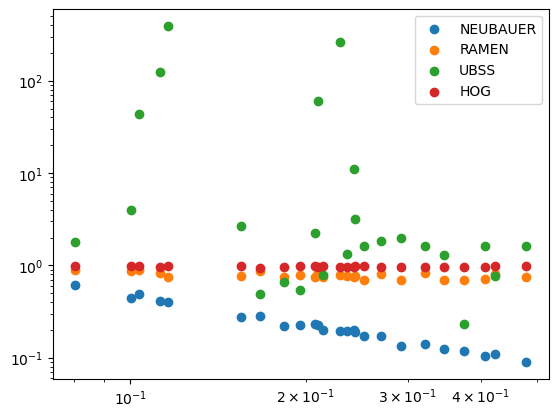

In [ ]:
csv_file = 'results_2.csv'
df  = pd.read_csv(csv_file)
print(df.keys())
plt.scatter(df['rmse_B2_x'], df['rmse_neubauer_x']/df['rmse_B2_x'], label = 'NEUBAUER')
plt.scatter(df['rmse_B2_x'], df['rmse_ramen_x']/df['rmse_B2_x'], label = 'RAMEN')
plt.scatter(df['rmse_B2_x'], df['rmse_ubss_x']/df['rmse_B2_x'], label = 'UBSS')
plt.scatter(df['rmse_B2_x'], df['rmse_hog_x']/df['rmse_B2_x'], label = 'HOG')
plt.xscale('log')
plt.yscale('log')
plt.legend()

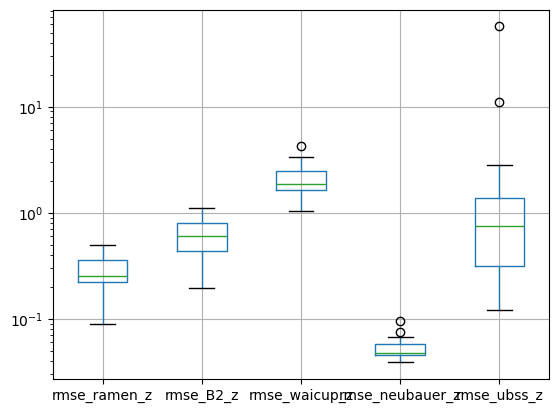

In [ ]:
df[['rmse_ramen_z',"rmse_B2_z","rmse_waicup_z", 'rmse_neubauer_z', 'rmse_ubss_z']].boxplot()
plt.yscale('log')

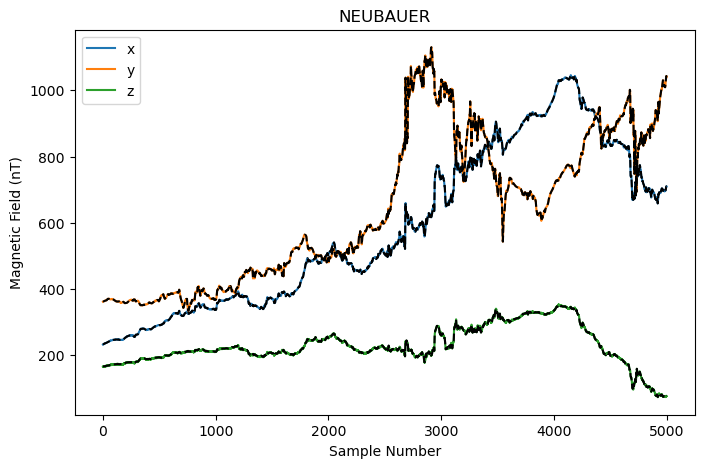

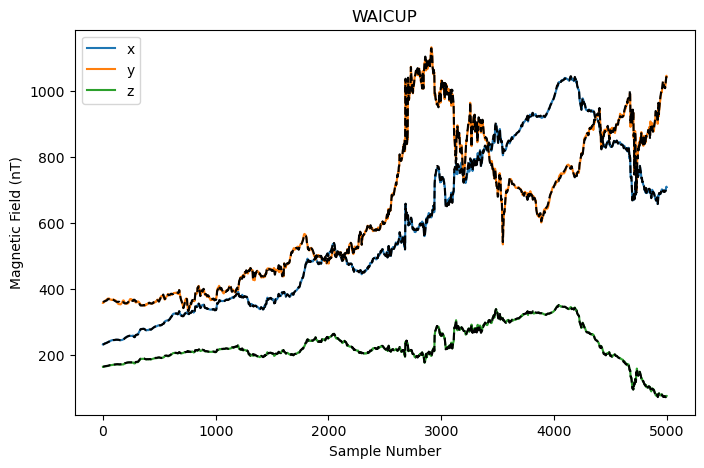

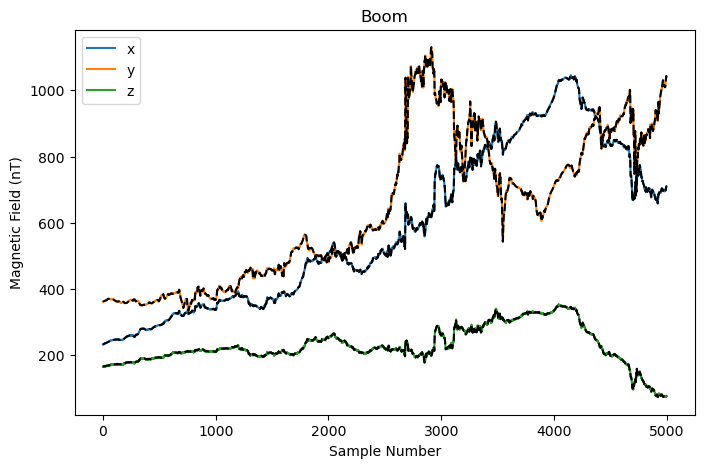

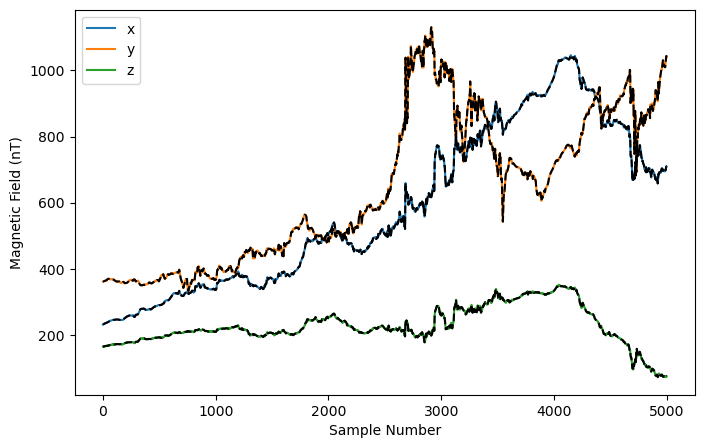

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

plt.plot(B_clean.T, label=['x','y','z'])
plt.plot(swarm.T, color = 'black', linestyle = '--')
plt.xlabel("Sample Number"); plt.ylabel("Magnetic Field (nT)")
plt.legend()
plt.title("NEUBAUER")


fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(result_waicup.T, label=['x','y','z'])
plt.plot(swarm.T, color = 'black', linestyle = '--')
plt.xlabel("Sample Number"); plt.ylabel("Magnetic Field (nT)")
plt.legend()
plt.title("WAICUP")

fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(B[-1].T, label=['x','y','z'])
plt.plot(swarm.T, color = 'black', linestyle = '--')
plt.xlabel("Sample Number"); plt.ylabel("Magnetic Field (nT)")
plt.legend()
plt.title("Boom")

fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(result_hog.T, label=['x','y','z'])
plt.plot(swarm.T, color = 'black', linestyle = '--')
plt.xlabel("Sample Number"); plt.ylabel("Magnetic Field (nT)")
plt.legend()

### Find Optimal spacecraft Center

In [ ]:
from scipy.optimize import minimize

def compute_mat_6b():
    """
    Computes the rho_i,k coefficients for each component and sensor.
    
    Parameters:
    - mag_positions: (n_sensors, 3) array of magnetometer positions.
    - spacecraft_center: (3,) array of the spacecraft center.
    
    Returns:
    - rho: (3, n_sensors) array where rho[i, k] corresponds to rho_{i,k}
    - sorted_indices: indices that sort the magnetometers for each axis i
    """
    # Compute relative positions
    pos = mag_positions - spacecraft_center  # (n_sensors, 3)

    # Compute distances from spacecraft center
    n_sensors = np.array(mag_positions).shape[0]
    mat_6b = np.zeros((n_sensors, n_sensors))

    pos = mag_positions - spacecraft_center  # (n_sensors, 3)
    r_k = np.linalg.norm(pos, axis=1) 

    sorted_indices = np.argsort(-r_k)
    r_sorted = r_k[sorted_indices]

    r1 = r_sorted[0]
    rho_k = r1 / r_sorted

    # Form the rho matrix
    mat_6b[0, :] = 1
    mat_6b[:, 0] = 1
    for i in range(1, n_sensors):
        mat_6b[1:, i] = rho_k[1:] ** (2 + i)

    return mat_6b, sorted_indices

def interference_cost(spacecraft_center, B_obs, mag_positions):
    """
    Cost function to minimize interference in magnetic field measurements.
    
    Parameters:
    - spacecraft_center: Current estimate of spacecraft center (3,)
    - B_obs: Observed magnetic field data (n_sensors, axes, n_samples)
    - mag_positions: Magnetometer positions (n_sensors, 3)
    
    Returns:
    - cost: Scalar value representing the total interference
    """
    # Compute rho_k with the current spacecraft center estimate
    mat_6b, sorted_indices = compute_mat_6b()
    B_sorted = B_obs[sorted_indices, :, :]
    
    # Compute the ambient magnetic field
    denom_det = np.linalg.det(mat_6b)
    if denom_det == 0:
        return np.inf  # Return a large cost if determinant is zero
    
    n_sensors, axes, n_samples = B_obs.shape
    B_amb = np.zeros((axes, n_samples))
    
    for sample in range(n_samples):
        for axis in range(axes):
            mat_6a = mat_6b.copy()
            mat_6a[:, 0] = B_sorted[:, axis, sample]
            numer_det = np.linalg.det(mat_6a)
            B_amb[axis, sample] = numer_det / denom_det
    
    # Estimate interference: difference between observed and ambient field
    interference = B_sorted - B_amb[np.newaxis, :, :]
    
    # Compute cost as sum of squared interference
    cost = np.sum(interference ** 2)
    return cost

# Initial spacecraft center estimate
spacecraft_center_estimate = np.mean(mag_positions, axis=0)

# Optimize spacecraft center
result = minimize(
    interference_cost,
    spacecraft_center_estimate,
    args=(np.copy(B), mag_positions),
    method='Nelder-Mead',  # Simplex method suitable for non-smooth functions
    options={'maxiter': 100, 'disp': True}
)

# Final spacecraft center estimate
spacecraft_center_optimal = result.x

Optimization terminated successfully.
         Current function value: 983241768960.549805
         Iterations: 8
         Function evaluations: 39


In [ ]:
print(spacecraft_center)
print(spacecraft_center_optimal)

[0.0136 0.0098 0.1681]
[0.0025 0.005  0.1875]
